In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [11]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
# ) for (i, j) in [(k, k) for k in [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2][:]]}
) for i in [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1][:] for j in [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1][:]}

[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[0, 1]
{0: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[0, 1]
{0: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[0, 1]
{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[0, 1]
{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 9375, (0, 0): 3125, (1, 1): 3125, (1, 0): 9375}}


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 9062, (0, 0): 3437, (1, 1): 3438, (1, 0): 9063}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[0, 1]
{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


In [12]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.5RPAREN
Loaded classifier for experiment from file: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.5RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.45RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.4RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.35RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.5, -0.3RPAREN
Training classifier for experiment: 

In [13]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==0]
    experiment.original_df = experiment.original_df.drop(['is_train'], axis=1)
    experiment.aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
    experiment.aux_df = experiment.aux_df.drop(['is_train'], axis=1)
    experiment.y_column = experiment.ds.ds.meta['y_column']

In [17]:
experiment.sampling_condition_dict['corr_btn_sens_and_output_per_subgroup']

(-0.2, -0.2)

In [33]:
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

In [56]:
result_dict_train = {}
result_dict_test = {}

for experiment_key in experiments:
    experiment = experiments[experiment_key]

    correlation = experiment.sampling_condition_dict['corr_btn_sens_and_output_per_subgroup']
    # result_dict_train[correlation] = {}
    # result_dict_test[correlation] = {}
    experiment.y_tr_pred = np.argmax(experiment.clf_only_on_test.predict_proba(experiment.X_train), axis=1)
    experiment.y_te_pred = np.argmax(experiment.clf_only_on_test.predict_proba(experiment.X_test), axis=1)

    subgroup_col_name = 'SEX'

    subgroup_vals_tr = experiment.X_train[f'{subgroup_col_name}_1'].to_numpy().ravel()
    subgroup_vals_te = experiment.X_test[f'{subgroup_col_name}_1'].to_numpy().ravel()

    sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())

    result_dict_train[correlation] = {
        'EOD': equalized_odds_difference(experiment.y_tr.ravel(), experiment.y_tr_pred, sensitive_features=subgroup_vals_tr),
        'DPD': demographic_parity_difference(experiment.y_tr.ravel(), experiment.y_tr_pred, sensitive_features=subgroup_vals_tr),
        'ASRD': np.ptp([experiment.correct_indices[subgroup_vals_te==i].mean() for i in [0, 1]])
    }
    
    result_dict_test[correlation] = {
        'EOD': equalized_odds_difference(experiment.y_te.ravel(), experiment.y_te_pred, sensitive_features=subgroup_vals_te),
        'DPD': demographic_parity_difference(experiment.y_te.ravel(), experiment.y_te_pred, sensitive_features=subgroup_vals_te),
        'ASRD': np.ptp([experiment.correct_indices[subgroup_vals_te==i].mean() for i in [0, 1]])
    }
    

In [57]:
result_dict_train_df = pd.DataFrame.from_dict(result_dict_train, orient='index')
result_dict_test_df = pd.DataFrame.from_dict(result_dict_test, orient='index')

In [77]:
for max_corr_val in [-0.5, -0.4, -0.3]:
    # max_corr_val = -0.5
    min_corr_val = -0.1
    temp_df = result_dict_train_df.loc[[(min_corr_val, max_corr_val), (min_corr_val, min_corr_val)]]
    temp_df.T.plot(kind='bar')

KeyError: 'None of [MultiIndex([(-0.1, -0.5),\n            (-0.1, -0.1)],\n           )] are in the [index]'

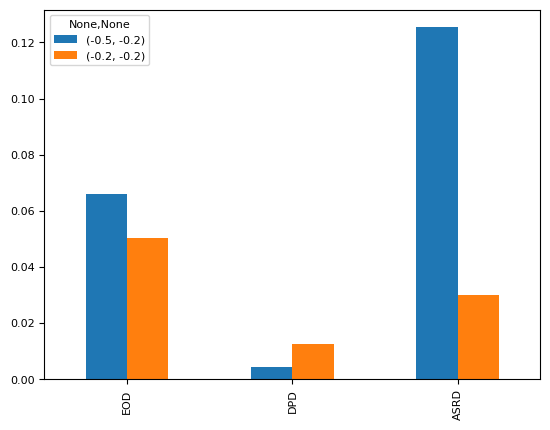

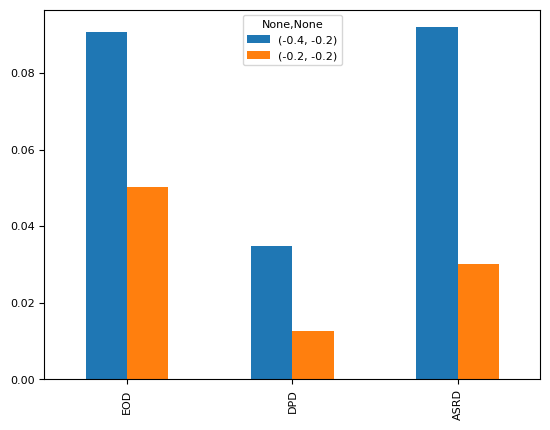

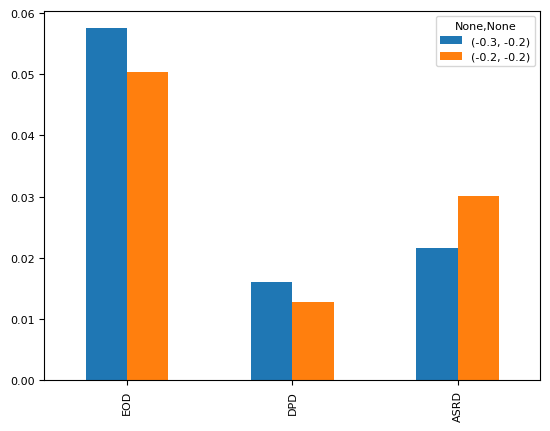

In [74]:
for max_corr_val in [-0.5, -0.4, -0.3]:
    # max_corr_val = -0.5
    min_corr_val = -0.2
    temp_df = result_dict_train_df.loc[[(max_corr_val, min_corr_val), (min_corr_val, min_corr_val)]]
    temp_df.T.plot(kind='bar')

<Axes: >

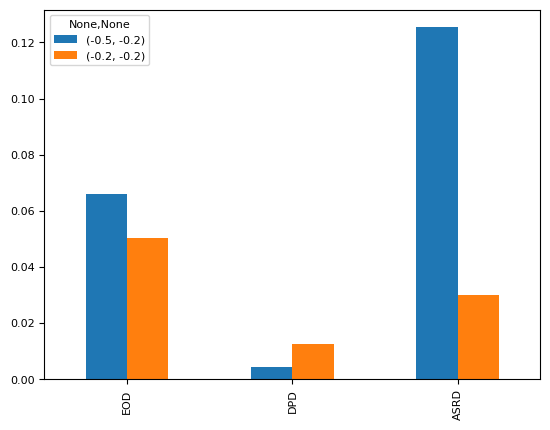

In [72]:
temp_df.T.plot(kind='bar')

In [68]:
temp_df.to_dict()

{'EOD': {(-0.5, -0.2): 0.06591999999999998,
  (-0.2, -0.2): 0.050319999999999976},
 'DPD': {(-0.5, -0.2): 0.0045200000000000795,
  (-0.2, -0.2): 0.012720000000000065},
 'ASRD': {(-0.5, -0.2): 0.12539999999999996,
  (-0.2, -0.2): 0.030120000000000036}}

In [58]:
result_dict_train_df

EOD      DPD     ASRD
-0.50 -0.50  0.07040  0.02572  0.00008
      -0.45  0.06928  0.01920  0.02492
      -0.40  0.07856  0.01504  0.05040
      -0.35  0.07912  0.02236  0.06788
      -0.30  0.06648  0.00432  0.09512
      -0.25  0.07648  0.01236  0.11592
      -0.20  0.06592  0.00452  0.12540
-0.45 -0.50  0.06152  0.02384  0.03532
      -0.45  0.06768  0.01824  0.00404
      -0.40  0.07152  0.02152  0.02368
      -0.35  0.07016  0.01420  0.05132
      -0.30  0.06920  0.01264  0.08080
      -0.25  0.07648  0.02252  0.13256
      -0.20  0.07200  0.01032  0.12800
-0.40 -0.50  0.05456  0.01600  0.05304
      -0.45  0.06784  0.03316  0.02748
      -0.40  0.04704  0.00156  0.00468
      -0.35  0.07552  0.02380  0.02880
      -0.30  0.05944  0.01280  0.05172
      -0.25  0.06664  0.01456  0.06808
      -0.20  0.09064  0.03480  0.09192
-0.35 -0.50  0.05200  0.01892  0.07940
      -0.45  0.05000  0.01940  0.05820
      -0.40  0.06536  0.02300  0.01488
      -0.35  0.05312  0.01452  0.00036
      -0.30  0.05664  0.01260  0.01632
      -0.25  0.08568  0.03768  0.03936
      -0.20  0.05576  0.01244  0.07276
-0.30 -0.50  0.04728  0.01916  0.10668
      -0.45  0.03896  0.00380  0.07828
      -0.40  0.05464  0.01900  0.05748
      -0.35  0.07152  0.02816  0.02852
      -0.30  0.04984  0.01176  0.00540
      -0.25  0.04424  0.00112  0.02148
      -0.20  0.05752  0.01612  0.02156
-0.25 -0.50  0.03640  0.00992  0.13612
      -0.45  0.04048  0.01216  0.09760
      -0.40  0.07024  0.02832  0.06676
      -0.35  0.05144  0.01060  0.06044
      -0.30  0.05264  0.01516  0.02676
      -0.25  0.03744  0.00444  0.00160
      -0.20  0.04432  0.00644  0.00296
-0.20 -0.50  0.04584  0.02396  0.15976
      -0.45  0.03176  0.00596  0.11648
      -0.40  0.05800  0.01932  0.10328
      -0.35  0.04696  0.01364  0.07192
      -0.30  0.05792  0.02240  0.05552
      -0.25  0.04768  0.01232  0.02056
      -0.20  0.05032  0.01272  0.03012

In [41]:
result_dict_test_df

EOD      DPD
-0.50 -0.50  0.031840  0.01368
      -0.45  0.017109  0.01068
      -0.40  0.010240  0.00016
      -0.35  0.011510  0.00800
      -0.30  0.009680  0.00116
      -0.25  0.013696  0.00248
      -0.20  0.016560  0.00484
-0.45 -0.50  0.035453  0.01444
      -0.45  0.020882  0.00576
      -0.40  0.025533  0.01544
      -0.35  0.012799  0.01076
      -0.30  0.006014  0.00392
      -0.25  0.015119  0.01268
      -0.20  0.005133  0.00144
-0.40 -0.50  0.044320  0.01568
      -0.45  0.045030  0.02388
      -0.40  0.015440  0.00228
      -0.35  0.025827  0.01552
      -0.30  0.016080  0.00720
      -0.25  0.015508  0.01128
      -0.20  0.023840  0.02160
-0.35 -0.50  0.045614  0.01024
      -0.45  0.033683  0.00568
      -0.40  0.038176  0.01612
      -0.35  0.021202  0.00924
      -0.30  0.018815  0.00472
      -0.25  0.040483  0.02812
      -0.20  0.011137  0.00284
-0.30 -0.50  0.061760  0.01988
      -0.45  0.033585  0.00276
      -0.40  0.044400  0.01612
      -0.35  0.039825  0.01872
      -0.30  0.030880  0.01116
      -0.25  0.017374  0.00032
      -0.20  0.024560  0.01008
-0.25 -0.50  0.061299  0.01180
      -0.45  0.046244  0.00748
      -0.40  0.052819  0.02460
      -0.35  0.040877  0.01356
      -0.30  0.041378  0.01220
      -0.25  0.023602  0.00368
      -0.20  0.022817  0.00168
-0.20 -0.50  0.071440  0.02056
      -0.45  0.051588  0.00852
      -0.40  0.061680  0.02292
      -0.35  0.044387  0.01232
      -0.30  0.046480  0.01844
      -0.25  0.037666  0.00932
      -0.20  0.024240  0.00436

In [28]:
equalized_odds_difference(experiment.y_tr.ravel(), experiment.y_tr_pred, sensitive_features=subgroup_vals)

0.050319999999999976

In [27]:
subgroup_vals.to_numpy().ravel()

array([0., 0., 0., ..., 1., 1., 1.])

In [21]:
result_dict_train = {}
result_dict_test = {}

for experiment_key in experiments:
    experiment = experiments[experiment_key]

    correlation = experiment.sampling_condition_dict['corr_btn_sens_and_output_per_subgroup']
    # result_dict_train[correlation] = {}
    # result_dict_test[correlation] = {}
    experiment.y_tr_pred = np.argmax(experiment.clf_only_on_test.predict_proba(experiment.X_train), axis=1)
    experiment.y_te_pred = np.argmax(experiment.clf_only_on_test.predict_proba(experiment.X_test), axis=1)

    subgroup_col_name = 'SEX'
    subgroup_name_dict = {0: 'Male', 1: 'Female'}
    subgroup_indices_dict_train = {j: np.argwhere(experiment.X_train[f'{subgroup_col_name}_1'].to_numpy().ravel() == j).ravel() for j in [0, 1]}
    subgroup_indices_dict_test = {j: np.argwhere(experiment.X_test[f'{subgroup_col_name}_1'].to_numpy().ravel() == j).ravel() for j in [0, 1]}

    result_dict_train[correlation] = {subgroup_name_dict[j]: 100 * (experiment.y_tr_pred[subgroup_indices_dict_train[j]] == experiment.y_tr.ravel()[subgroup_indices_dict_train[j]]).mean() for j in [0, 1]}
    result_dict_test[correlation] = {subgroup_name_dict[j]: 100 * (experiment.y_te_pred[subgroup_indices_dict_test[j]] == experiment.y_te.ravel()[subgroup_indices_dict_test[j]]).mean() for j in [0, 1]}

    result_dict_train_df = pd.DataFrame.from_dict(result_dict_train, orient='index')
    result_dict_test_df = pd.DataFrame.from_dict(result_dict_test, orient='index')


In [23]:
result_dict_train_df

Male  Female
-0.50 -0.50  71.856  76.324
      -0.45  72.076  77.084
      -0.40  71.116  77.468
      -0.35  72.364  78.040
      -0.30  71.932  78.148
      -0.25  72.116  78.528
      -0.20  72.380  78.520
-0.45 -0.50  73.016  76.784
      -0.45  72.204  77.148
      -0.40  72.408  77.408
      -0.35  72.536  78.132
      -0.30  72.292  77.948
      -0.25  72.736  78.132
      -0.20  72.080  78.248
-0.40 -0.50  73.008  76.864
      -0.45  73.880  77.348
      -0.40  73.364  77.912
      -0.35  72.976  78.148
      -0.30  73.412  78.076
      -0.25  73.148  78.356
      -0.20  73.220  78.804
-0.35 -0.50  73.788  77.096
      -0.45  73.868  76.928
      -0.40  73.340  77.576
      -0.35  74.000  77.860
      -0.30  73.796  78.200
      -0.25  73.256  78.056
      -0.20  73.920  78.252
-0.30 -0.50  74.424  77.236
      -0.45  74.020  77.536
      -0.40  74.324  77.888
      -0.35  74.044  78.380
      -0.30  74.460  78.268
      -0.25  74.032  78.344
      -0.20  74.240  78.380
-0.25 -0.50  73.940  76.588
      -0.45  74.408  77.240
      -0.40  73.192  77.384
      -0.35  74.344  78.428
      -0.30  74.512  78.260
      -0.25  74.528  77.828
      -0.20  74.576  78.364
-0.20 -0.50  75.168  77.356
      -0.45  74.512  77.092
      -0.40  73.828  77.696
      -0.35  74.692  78.024
      -0.30  74.956  78.508
      -0.25  74.708  78.244
      -0.20  74.780  78.540

In [22]:
result_dict_test_df

Male  Female
-0.50 -0.50  84.568  86.384
      -0.45  84.412  85.052
      -0.40  85.244  84.236
      -0.35  84.324  83.976
      -0.30  83.996  83.144
      -0.25  84.252  83.128
      -0.20  84.228  83.056
-0.45 -0.50  83.376  85.480
      -0.45  83.428  84.940
      -0.40  83.500  84.512
      -0.35  83.788  83.584
      -0.30  83.560  83.772
      -0.25  83.776  83.532
      -0.20  83.240  82.868
-0.40 -0.50  83.004  85.868
      -0.45  82.912  85.024
      -0.40  82.712  84.028
      -0.35  83.020  84.048
      -0.30  82.092  82.980
      -0.25  82.392  82.812
      -0.20  82.728  82.952
-0.35 -0.50  82.048  85.588
      -0.45  82.220  85.020
      -0.40  82.320  84.528
      -0.35  82.924  84.120
      -0.30  82.316  83.728
      -0.25  82.548  83.784
      -0.20  82.272  83.104
-0.30 -0.50  81.224  85.412
      -0.45  81.708  84.788
      -0.40  81.200  84.028
      -0.35  81.292  83.400
      -0.30  81.392  83.364
      -0.25  81.288  82.996
      -0.20  81.708  83.156
-0.25 -0.50  81.204  86.156
      -0.45  81.048  84.924
      -0.40  82.044  84.868
      -0.35  81.212  83.944
      -0.30  80.784  83.704
      -0.25  80.632  82.624
      -0.20  80.992  83.108
-0.20 -0.50  80.312  85.400
      -0.45  80.428  84.732
      -0.40  80.756  84.632
      -0.35  80.900  84.104
      -0.30  80.232  83.036
      -0.25  80.364  83.196
      -0.20  80.600  82.588

In [23]:
result_dict_train

{-0.5: {0: 71.856, 1: 76.324},
 -0.45: {0: 72.20400000000001, 1: 77.14800000000001},
 -0.4: {0: 73.532, 1: 78.01599999999999},
 -0.35: {0: 74.72, 1: 78.704},
 -0.3: {0: 74.55199999999999, 1: 78.50399999999999},
 -0.25: {0: 74.26, 1: 78.092},
 -0.2: {0: 74.69200000000001, 1: 78.24}}

In [25]:
result_dict_test

{-0.5: {0: 84.568, 1: 86.384},
 -0.45: {0: 83.428, 1: 84.94},
 -0.4: {0: 79.372, 1: 81.972},
 -0.35: {0: 79.984, 1: 82.25200000000001},
 -0.3: {0: 78.99199999999999, 1: 81.46799999999999},
 -0.25: {0: 76.452, 1: 79.036},
 -0.2: {0: 75.944, 1: 79.204}}

In [7]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices = ~experiment.correct_indices
    experiment.sensitive_column = experiment.ds.ds.meta["sensitive_column"]

In [8]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    try:
        experiment.all_vuln_scores = np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy')
    except:
        experiment.all_vuln_scores = np.array([get_vulnerability_score(experiment, experiment.X_test, experiment.y_te, experiment.original_df, index, k=4) for index in tqdm(experiment.X_test.index)])
        np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy', experiment.all_vuln_scores)
    experiment.all_vuln_scores_rounded = np.round(experiment.all_vuln_scores)
    experiment.vuln_accuracy = accuracy_score(experiment.correct_indices, experiment.all_vuln_scores_rounded)

In [64]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.correct_indices_LOMIA = (sens_pred_LOMIA == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices_LOMIA = ~experiment.correct_indices_LOMIA
    experiment.vuln_accuracy_LOMIA = accuracy_score(experiment.correct_indices_LOMIA, experiment.all_vuln_scores_rounded)

In [33]:
planets[['distance', 'method']]

,distance,method
0,77.40,Radial Velocity
1,56.95,Radial Velocity
2,19.84,Radial Velocity
3,110.62,Radial Velocity
4,119.47,Radial Velocity
...,...,...
1030,172.00,Transit
1031,148.00,Transit
1032,174.00,Transit
1033,293.00,Transit


<Axes: xlabel='distance', ylabel='Count'>

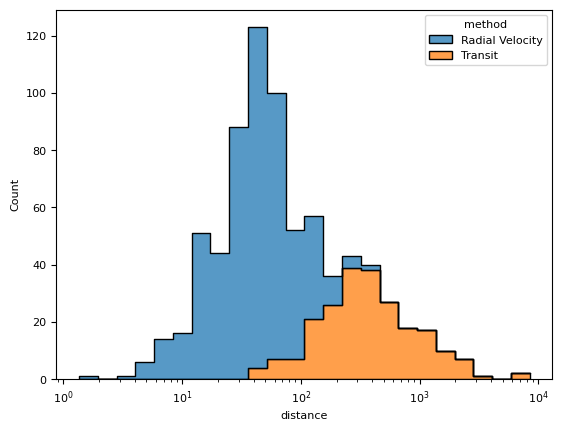

In [29]:
planets = sns.load_dataset("planets")
# sns.histplot(data=planets, x="distance")
sns.histplot(
    data=planets, x="distance", hue="method",
    hue_order=["Radial Velocity", "Transit"],
    log_scale=True, element="step", stat="count", common_norm=False, multiple='stack'
)

In [61]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18

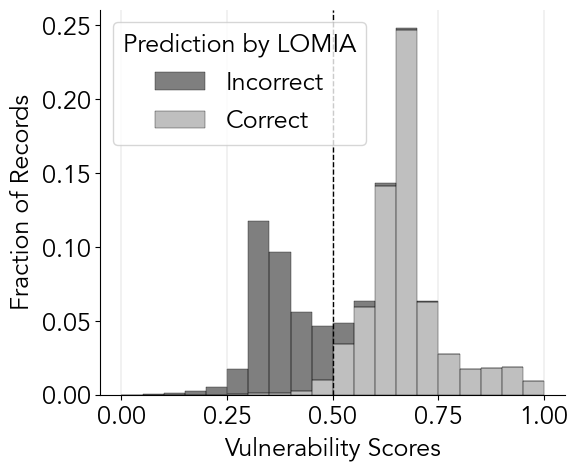

In [79]:
experiment = experiments['corr_btn_sens_and_out_(-0.3, -0.3)']
draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices_LOMIA, experiment.incorrect_indices_LOMIA, 'LOMIA')
plt.show()

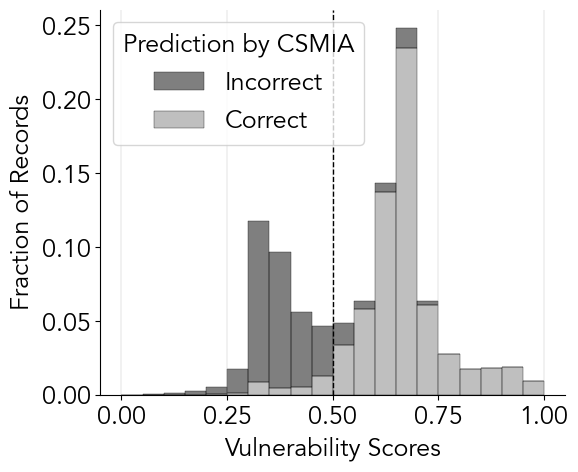

In [80]:
experiment = experiments['corr_btn_sens_and_out_(-0.3, -0.3)']
draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices, experiment.incorrect_indices)
plt.show()

In [84]:
from disparity_inference_utils import get_corr_btn_sens_and_out_per_subgroup

def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate
}
performance_dict = {}
for metric in eval_func:
    performance_dict[metric] = {}
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        correlation = round(get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {}), 2)
        # print(experiment.sampling_condition_dict['corr_btn_sens_and_output_per_subgroup'])
        CSMIA_performance = 100 * eval_func[metric](experiment.correct_indices, experiment.all_vuln_scores_rounded)
        LOMIA_performance = 100 * eval_func[metric](experiment.correct_indices_LOMIA, experiment.all_vuln_scores_rounded)
        performance_dict[metric][correlation] = {
            'CSMIA': CSMIA_performance,
            'LOMIA': LOMIA_performance
        }

In [98]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18

def plot_result(performance_dict, metric='accuracy', save_fig=False, name='Census19'):
    attacks = ['CSMIA', 'LOMIA']
    metric_name_dict = {'accuracy': 'Risk Prediction Accuracy', 'f1': 'F1 Score', 'fpr': 'False Positive Rate', 'precision': 'Precision', 'recall': 'Recall'}
    df = pd.DataFrame.from_dict(performance_dict[metric], orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}'], label=attack, marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)
    extra = Line2D([0], [0], color='white', label='Census19\n\n\n')

    # Create legend with custom entry
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(extra)
    labels.append('Additional Information')

    # Create legend with custom entry
    plt.legend(handles=handles, labels=labels, loc='upper right')
    # plt.legend()
    plt.xlabel(f'Correlation of Census-19 ')
    plt.ylabel(metric_name_dict[metric])
    plt.ylim(0, 100)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if save_fig:
        plt.savefig(f'vuln_scores_{metric}_{experiment.ds.ds.name}.png')
    else:
        plt.show()

In [41]:
experiment.ds.ds.name

'Census19'

In [88]:
from matplotlib.lines import Line2D

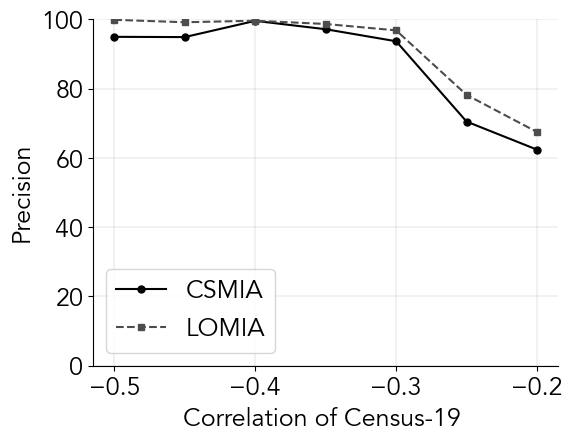

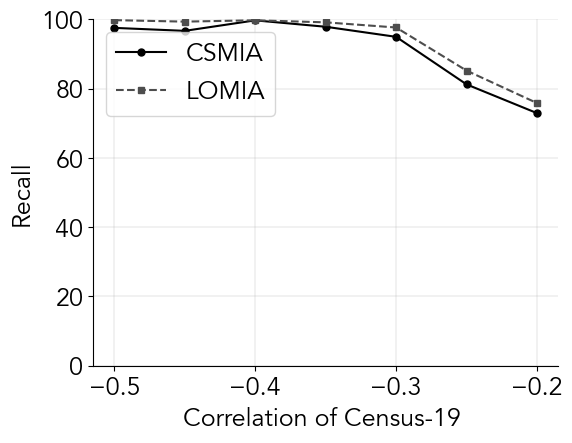

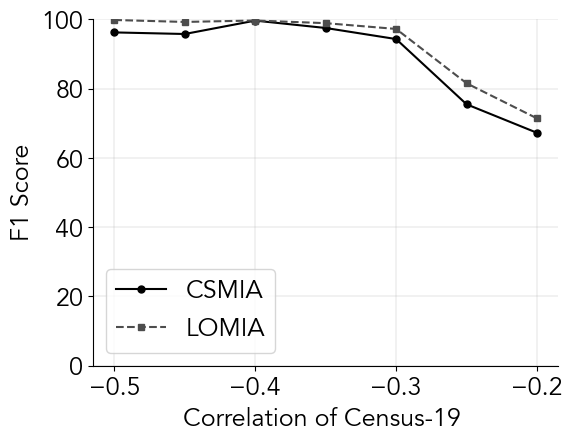

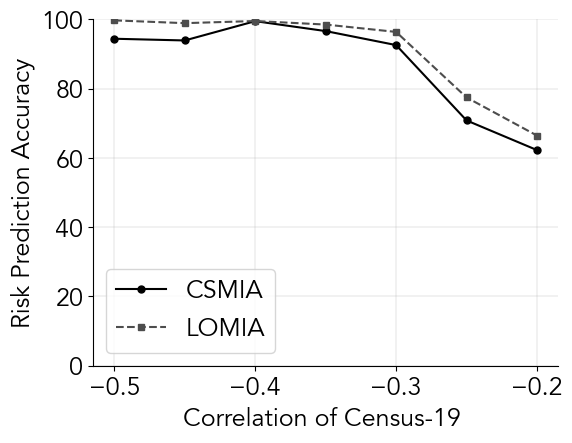

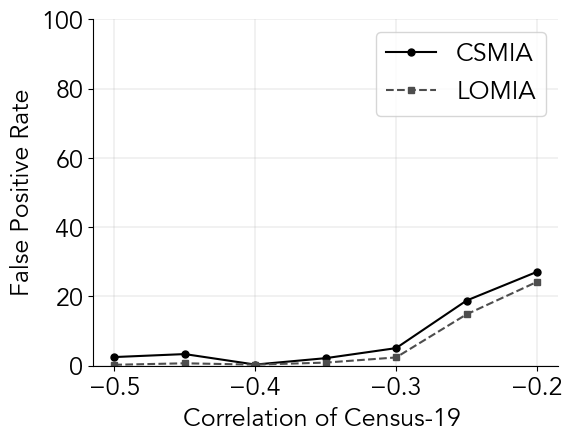

In [99]:
for metric in eval_func:
    plot_result(performance_dict, metric=metric, save_fig=True)

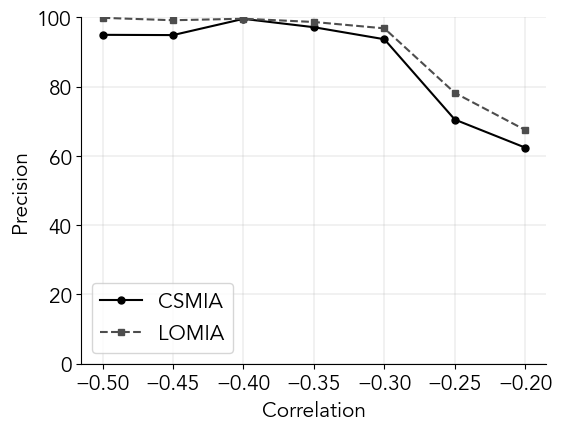

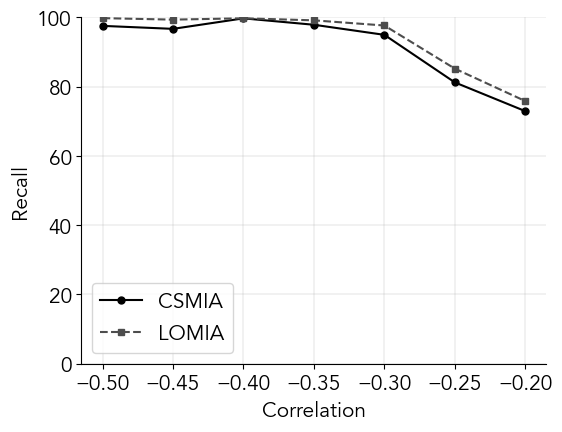

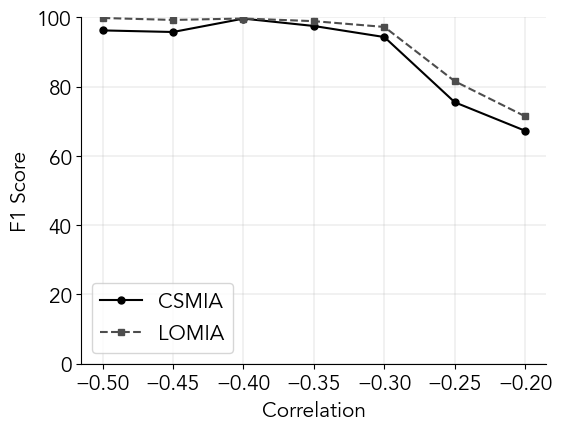

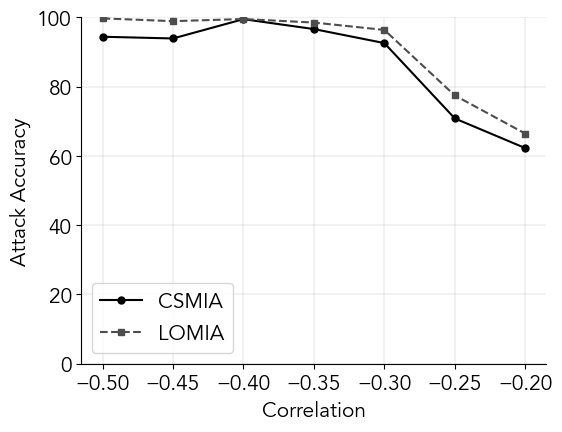

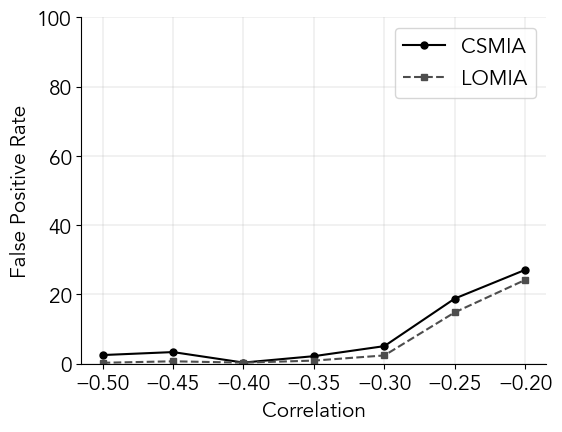

In [45]:
for metric in eval_func:
    plot_result(performance_dict, metric=metric, save_fig=True)

In [12]:
print(vuln_accuracies_CSMIA)
print(vuln_accuracy_LOMIA)

[0.94368, 0.9387, 0.9944, 0.9658, 0.92536, 0.7079, 0.6223]
[0.9967, 0.98864, 0.99482, 0.9846, 0.96336, 0.7742, 0.66416]


In [11]:
vuln_accuracies_CSMIA = [experiments[experiment_key].vuln_accuracy for experiment_key in experiments]
vuln_accuracy_LOMIA = [experiments[experiment_key].vuln_accuracy_LOMIA for experiment_key in experiments]
corrs = [-0.4, -0.35, -0.3, -0.25, -0.2]


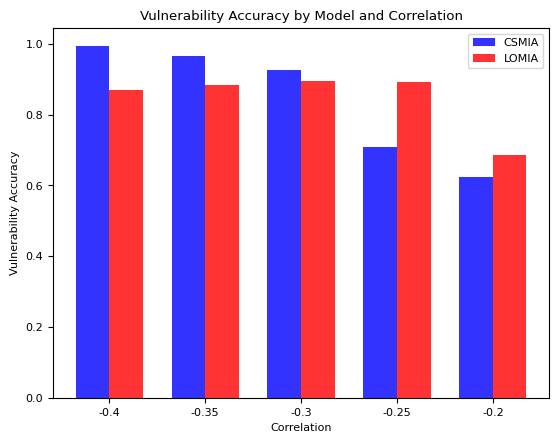

In [47]:
n_groups = len(corrs)

# Create figure and axis
fig, ax = plt.subplots()

# Index for the groups
index = np.arange(n_groups)

# Bar width
bar_width = 0.35

# Opacity for the bars
opacity = 0.8

# Plotting
rects1 = ax.bar(index, vuln_accuracies_CSMIA, bar_width,
                alpha=opacity, color='b',
                label='CSMIA')

rects2 = ax.bar(index + bar_width, vuln_accuracy_LOMIA, bar_width,
                alpha=opacity, color='r',
                label='LOMIA')

# Adding labels, title and axes ticks
ax.set_xlabel('Correlation')
ax.set_ylabel('Vulnerability Accuracy')
ax.set_title('Vulnerability Accuracy by Model and Correlation')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrs)
ax.legend()

# Show the plot
plt.show()

# add bar for attack performance

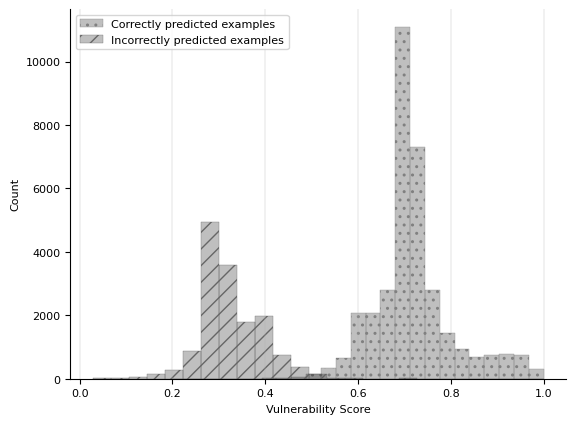

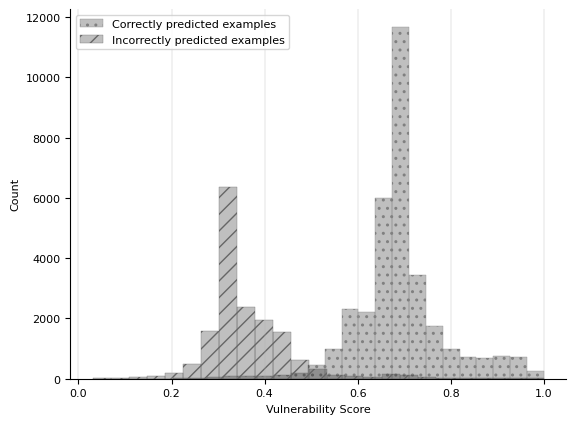

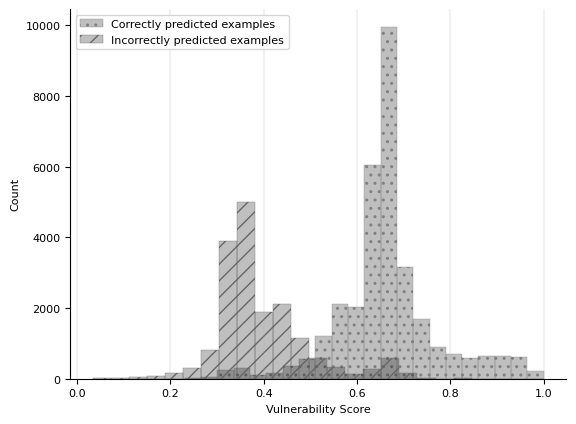

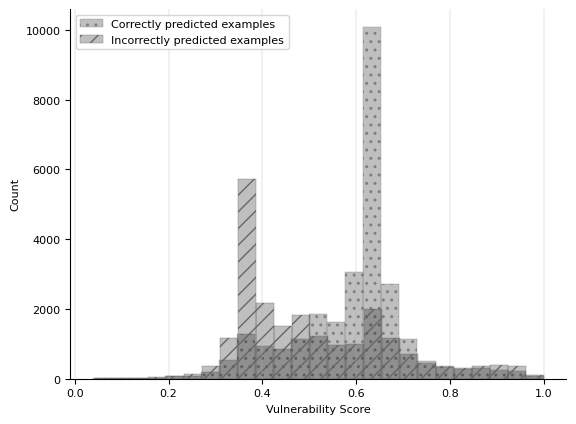

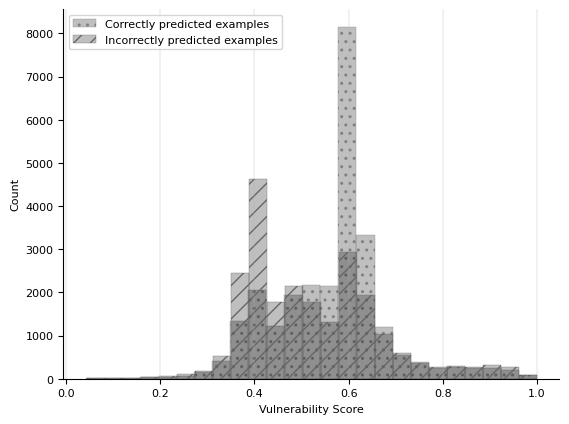

In [48]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices, experiment.incorrect_indices)
    plt.show()

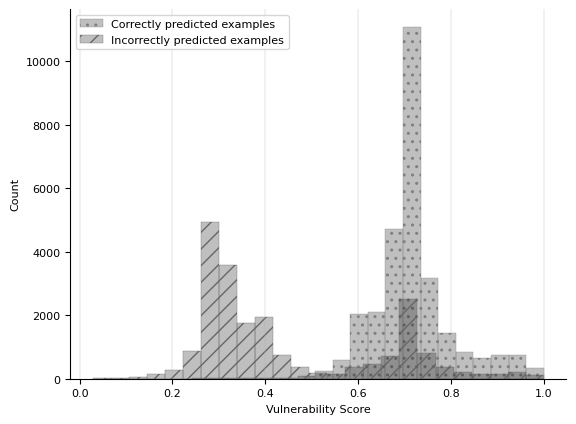

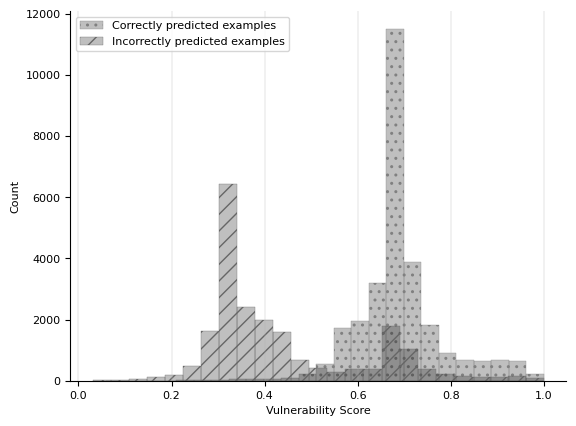

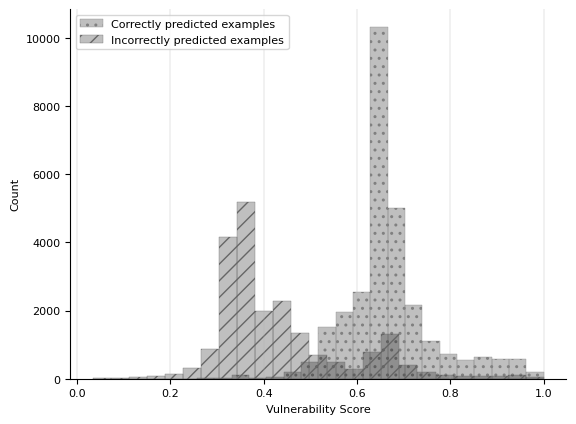

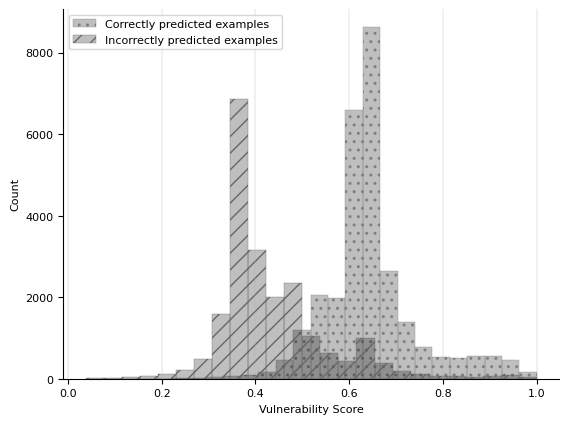

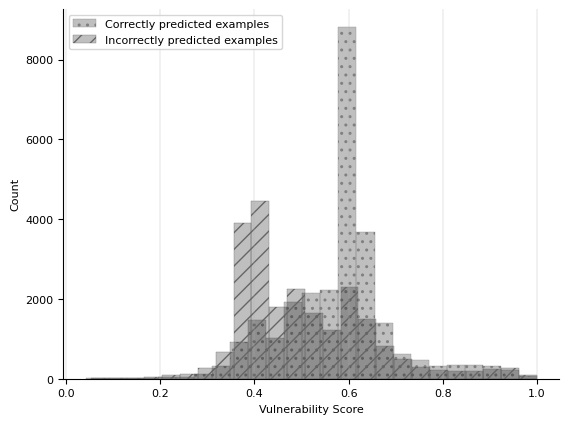

In [49]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    draw_hist_plot(experiment.all_vuln_scores, experiment.correct_indices_LOMIA, experiment.incorrect_indices_LOMIA)
    plt.show()

In [27]:
# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'Avenir' # Avenir, Optima, Lucida Grande, Trebuchet MS, Gill Sans
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'regular'

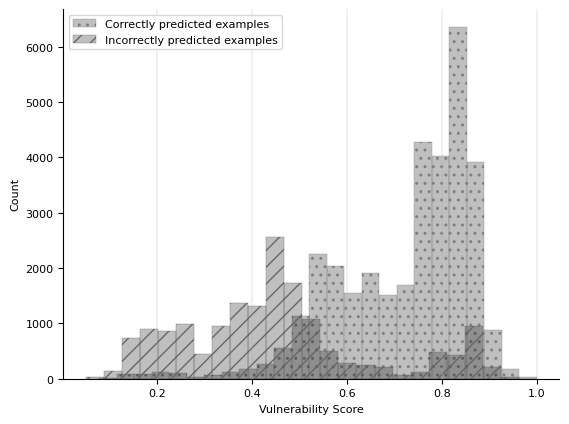

In [92]:
draw_hist_plot(all_vuln_scores, correct_indices, incorrect_indices)

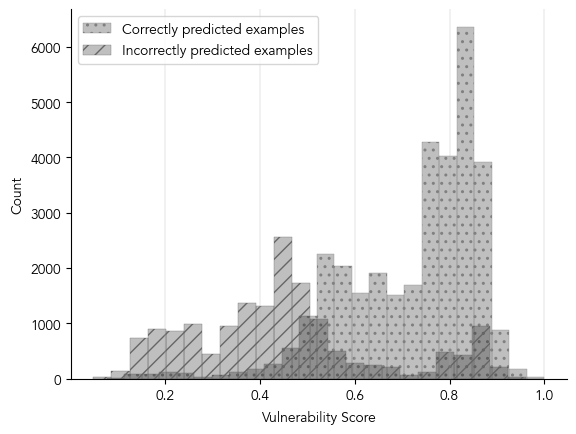

In [88]:
fig, ax = plt.subplots()
sns.histplot(all_vuln_scores[correct_indices], label='Correctly predicted examples', element='bars', stat='count', bins=25, linewidth=0.25, alpha=0.5, color="grey", hatch='..', edgecolor='grey')
# sns.histplot(all_vuln_scores[correct_indices], label='Correctly predicted examples', element='bars', stat='count', bins=25, linewidth=0, alpha=0.01, color=(0, 0, 0, 0), hatch='..', edgecolor='grey')
sns.histplot(all_vuln_scores[incorrect_indices], label='Incorrectly predicted examples', element='bars', stat='count', bins=25, linewidth=0.25, alpha=0.25, color="black", hatch='//', edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('Vulnerability Score')
plt.ylabel('Count')
plt.grid(True, linestyle='-', linewidth=0.25, axis='x')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
sns.despine()
plt.show()

In [18]:
all_vuln_scores_rounded = np.round(all_vuln_scores)

In [19]:
accuracy_score(correct_indices, all_vuln_scores_rounded)

0.86338

In [21]:
from sklearn.metrics import RocCurveDisplay

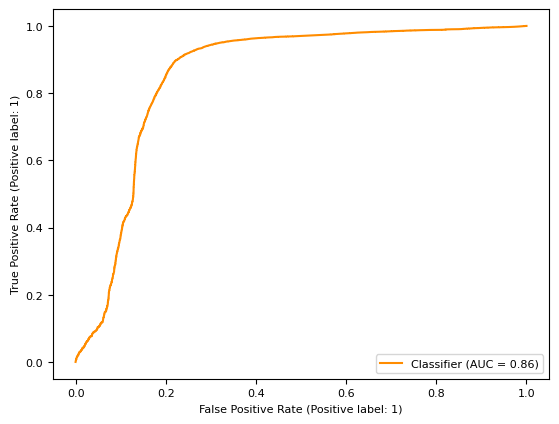

In [26]:
RocCurveDisplay.from_predictions(correct_indices, all_vuln_scores, pos_label=1, 
    color="darkorange")

In [111]:
all_vuln_scores_aux = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_train, experiment.y_tr, aux_df, index, k=4) for index in experiment.X_train.index])

In [112]:
np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores_aux.pkl', all_vuln_scores_aux)

In [18]:
np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores_aux.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '<PATH_TO_MODEL>/Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN_vuln_scores_aux.pkl'

In [115]:
aux_df_onehot = experiment.ds.ds.df.copy()

aux_df_onehot = aux_df_onehot[aux_df_onehot["is_train"]==1].drop("is_train", axis=1)

In [118]:
all_vuln_scores_rounded_aux = np.round(all_vuln_scores_aux)

In [122]:
X_attack, y_sens = experiment.ds.ds.get_attack_df(aux_df_onehot)
X_attack = X_attack.astype(float)
vuln_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(64, 32, 16, 8))
vuln_clf.fit(X_attack, all_vuln_scores_rounded_aux)

MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), max_iter=500, random_state=42)

In [123]:
acc = 100 * vuln_clf.score(X_attack, all_vuln_scores_rounded_aux)
print(f'Inverse accuracy with test size : {acc}')

Inverse accuracy with test size : 78.29


In [149]:
original_df_onehot = experiment.ds.ds.df.copy()

original_df_onehot = original_df_onehot[original_df_onehot["is_train"]==0].drop("is_train", axis=1).reset_index(drop=True)

In [126]:
X_attack_orig, _ = experiment.ds.ds.get_attack_df(original_df_onehot)
X_attack_orig = X_attack_orig.astype(float)

In [127]:
vuln_preds = vuln_clf.predict(X_attack_orig)

In [132]:
(vuln_preds==correct_indices).mean()

0.65362

In [156]:
aux_samp_from_orig = np.random.choice(original_df_onehot.index, 5000, False)

In [157]:
aux_from_orig_onehot = original_df_onehot.iloc[aux_samp_from_orig]
X_attack_aux_from_orig, _ = experiment.ds.ds.get_attack_df(aux_from_orig_onehot)
X_attack_aux_from_orig = X_attack_aux_from_orig.astype(float)
vuln_scores_aux_from_orig = all_vuln_scores_rounded_aux[aux_samp_from_orig]

In [158]:
vuln_clf_w_5000 = model_utils.get_model(max_iter=500, hidden_layer_sizes=(64, 32, 16, 8), verbose=True, learning_rate='adaptive')
vuln_clf_w_5000.fit(X_attack_aux_from_orig, vuln_scores_aux_from_orig)

Iteration 1, loss = 0.67614468
Iteration 2, loss = 0.63750032
Iteration 3, loss = 0.63327052
Iteration 4, loss = 0.63058656
Iteration 5, loss = 0.62783505
Iteration 6, loss = 0.62579345
Iteration 7, loss = 0.62300825
Iteration 8, loss = 0.61967103
Iteration 9, loss = 0.61685222
Iteration 10, loss = 0.61173342
Iteration 11, loss = 0.60660021
Iteration 12, loss = 0.60196004
Iteration 13, loss = 0.59636308
Iteration 14, loss = 0.59010240
Iteration 15, loss = 0.58234509
Iteration 16, loss = 0.57310863
Iteration 17, loss = 0.56525822
Iteration 18, loss = 0.55597277
Iteration 19, loss = 0.54657120
Iteration 20, loss = 0.53803313
Iteration 21, loss = 0.52475907
Iteration 22, loss = 0.52119457
Iteration 23, loss = 0.51065466
Iteration 24, loss = 0.49937228
Iteration 25, loss = 0.48931758
Iteration 26, loss = 0.47608382
Iteration 27, loss = 0.46637647
Iteration 28, loss = 0.45470315
Iteration 29, loss = 0.45163349
Iteration 30, loss = 0.43971565
Iteration 31, loss = 0.44285496
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), learning_rate='adaptive',
              max_iter=500, random_state=42, verbose=True)

In [154]:
vuln_preds_ver_2 = vuln_clf.predict(X_attack_orig)

In [155]:
(vuln_preds_ver_2==correct_indices).mean()

0.70222

In [159]:
vuln_preds_ver_3 = vuln_clf_w_5000.predict(X_attack_orig)

In [1]:
(vuln_preds_ver_3==correct_indices).mean()

NameError: name 'vuln_preds_ver_3' is not defined

In [67]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, original_df, index, k=4) for index in case_2_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, original_df, index, k=4) for index in case_2_incorrect_indices[:]])

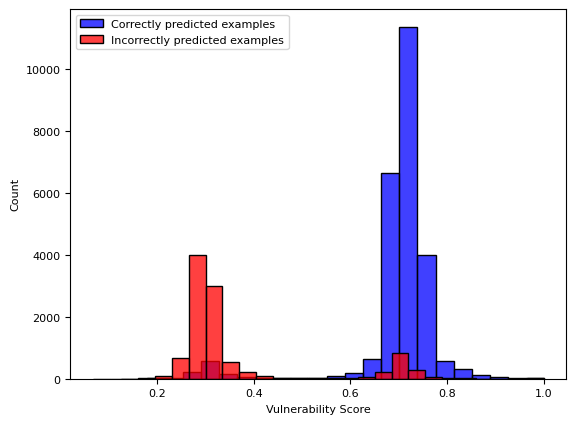

In [68]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Vulnerability Score')
plt.ylabel('Count')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [44]:
index = case_2_incorrect_indices[400]

print(get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.08781601583668741


In [45]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_mean_confidence_distance_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_incorrect_indices[:]])

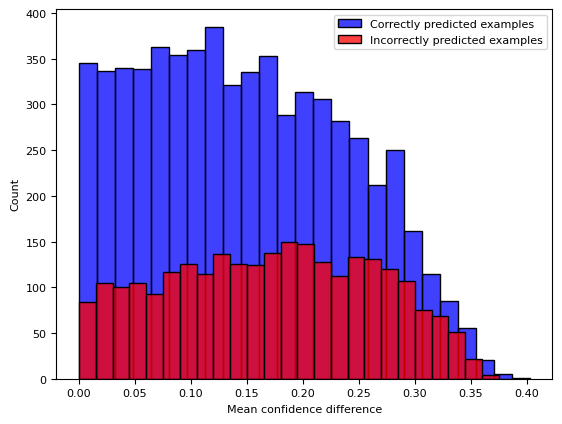

In [46]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Mean confidence difference')
plt.ylabel('Count')
# plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [97]:
index = case_2_correct_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.8181818181818182


In [98]:
index = case_2_incorrect_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.9588014981273408


In [99]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5) for index in case_1_incorrect_indices[:]])

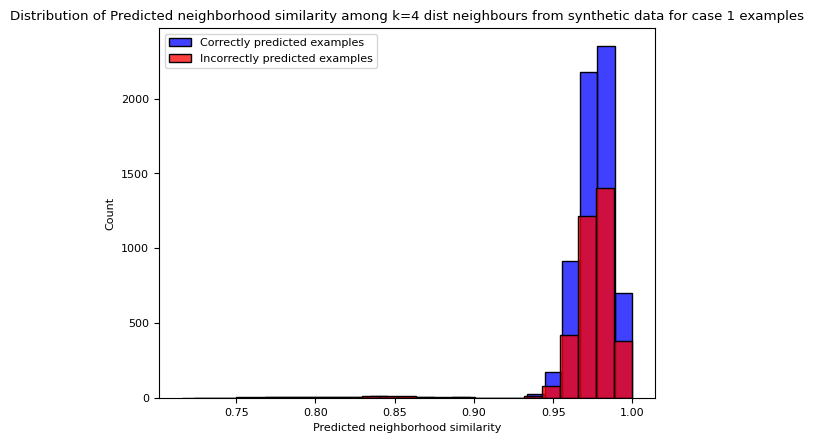

In [100]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [126]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_incorrect_indices[:]])

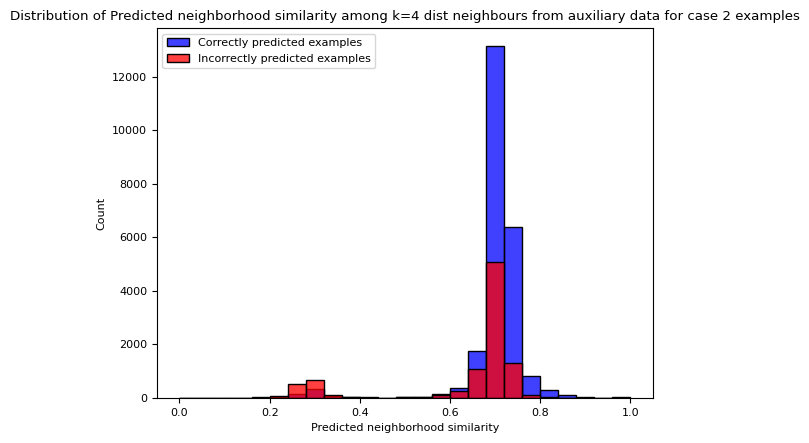

In [127]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from auxiliary data for case 2 examples')
plt.legend()
plt.show()

In [101]:
temp_df = original_df.iloc[:5]

In [102]:
temp_df

,AGEP,COW,SCHL,MAR,RAC1P,SEX,DREM,DPHY,DEAR,DEYE,WKHP,WAOB,ST,PINCP
50000,61,0,20,0,0,0,0,0,0,0,40,0,33,0
50001,67,6,23,0,0,0,0,0,0,0,40,3,9,0
50002,50,3,21,0,0,0,0,0,0,0,40,2,9,0
50003,39,6,20,0,0,0,0,0,0,0,80,0,23,0
50004,34,0,18,0,0,0,0,0,1,0,50,0,38,0


In [106]:
temp_df.at[50000, 'MAR'] = 1

In [107]:
temp_df

,AGEP,COW,SCHL,MAR,RAC1P,SEX,DREM,DPHY,DEAR,DEYE,WKHP,WAOB,ST,PINCP
50000,61.0,0.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,33.0,0
50001,67.0,6.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,3.0,9.0,0
50002,50.0,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0,9.0,0
50003,39.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,23.0,0
50004,34.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,0.0,38.0,0
0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
experiment.dist_matrix = experiment.dist_matrix.T

In [21]:
sens_pred_random, _ = CSMIA_attack(experiment.clf_only_on_test, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.ds.ds.meta)

In [42]:
index = case_2_correct_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.28294117647058825

In [43]:
index = case_2_incorrect_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.004201680672268907

In [32]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [44]:
k = 4
perc_same_sens_val_pred_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_correct_indices])
perc_same_sens_val_pred_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_incorrect_indices])

<Axes: ylabel='Density'>

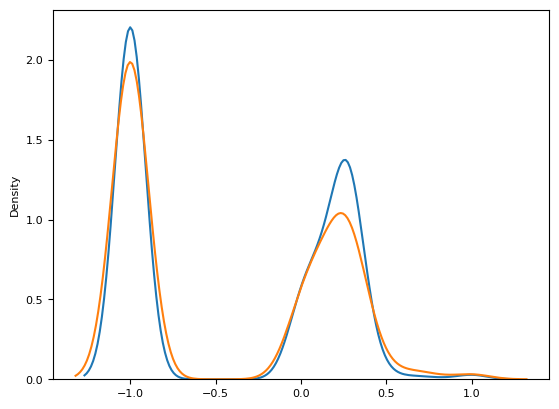

In [45]:
sns.kdeplot(perc_same_sens_val_pred_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_pred_incorrect, label='Incorrectly predicted examples')

In [96]:
for idx in range(1):
    index = case_2_correct_indices[idx+50]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

1.0


In [97]:
for idx in range(1):
    index = case_2_incorrect_indices[idx+2000]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

0.0


In [81]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [ ]:
perc_same_sens_val_correct

In [ ]:
perc_same_sens_val_incorrect

In [106]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_correct_indices[-1000:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_incorrect_indices[:1000]])

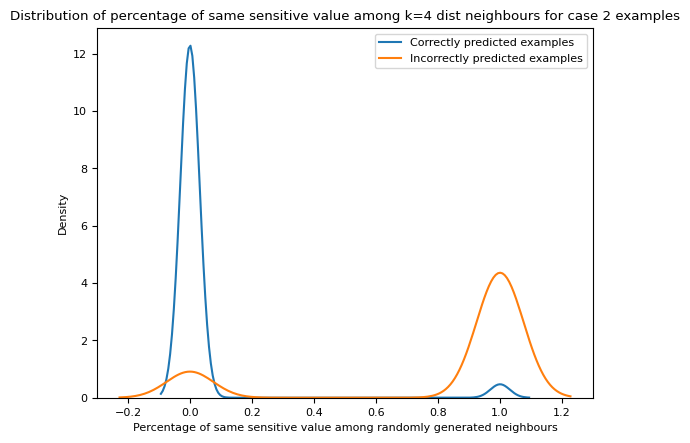

In [40]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among randomly generated neighbours')
plt.ylabel('Density')
plt.title(f'Distribution of percentage of same sensitive value among k={k} dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [107]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_correct, nan=-1))

Counter({0.0: 774, -1.0: 226})

In [108]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_incorrect, nan=-1))

Counter({1.0: 978, -1.0: 22})

In [9]:
experiment.X_random_df[['MAR', 'PINCP']].head(10)

,MAR,PINCP
5,0,0
6,1,1
7,0,0
8,0,0
9,1,0
12,1,1
14,0,0
16,1,0
18,0,0
23,0,0
